In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, SGD


In [0]:
%matplotlib inline

In [0]:
print(tf.__version__)

2.2.0


In [0]:
# Import NLTK libraries for text processing
import nltk
nltk.download('stopwords') # Get stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Import in the CSV file
In the CSV file, the column "category" is the label that we want to train the classification model on.  There are 4 distinct values:

* Access Controls
* Audit Logging
* Filesystem Security
* System Services

In the source file, the text columns are split into 5 columns: *title, description, rationale, impact, recommendation*.  We will concatenate each of them together into the stream of text that we will train the model on.


In [0]:
csv_file = 'input_rhel_controls.csv'
input_df = pd.read_csv(csv_file)
input_df.fillna(' ', inplace=True) # Replace empty columns in description fields with space

# Import and clean CSV file


In [0]:
def combine_text(row):
  output_string = str(row.title) + '\n'\
                  + str(row.description) + '\n'\
                  + str(row.rationale) + '\n'\
                  + str(row.impact) + '\n'\
                  + str(row.recommendation) 
  return output_string

# Strip the starting numbered text from title (e.g. 1.1.1)
# We simply split the string on space, and join back everything after
# the first space, which effectively removes the numbered text
def remove_numbered_title(row):
  full_string = row['title']
  split_list = full_string.split()
  cleaned_string = ' '.join(split_list[1:])
  
  return(cleaned_string)

input_df['title'] = input_df.apply(lambda row: remove_numbered_title(row), axis=1)

# Combine the 5 description columns into a column called full_description
input_df['full_description'] = input_df.apply(lambda row: combine_text(row), axis=1)

# Ensure labels are on single word boundaries since we will need to tokenize later
# Remove all spaces
def remove_space(row):
  output_string = str(row.get('category', '?'))
  return output_string.replace(' ', '')

input_df['category'] = input_df.apply(lambda row: remove_space(row), axis=1)

# Drop everything except the category label and full_description
df = input_df[['category', 'full_description']]

# Shuffle the df
df = df.sample(frac = 1).reset_index(drop=True)

In [0]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category          211 non-null    object
 1   full_description  211 non-null    object
dtypes: object(2)
memory usage: 3.4+ KB


,category,full_description
0,SystemServices,Ensure permissions on /etc/hosts.deny are conf...
1,FilesystemPermissions,Ensure separate partition exists for /home\nTh...
2,AuditLogging,Ensure audit logs are not automatically delete...
3,SystemServices,Ensure ICMP redirects are not accepted - 'net....
4,AccessControls,Ensure the MCS Translation Service (mcstrans) ...
5,SystemServices,Ensure loopback traffic is configured\nConfigu...
6,SystemServices,Ensure gpgcheck is globally activated\nThe 'gp...
7,AuditLogging,Ensure events that modify user/group informati...
8,SystemServices,Ensure permissions on /etc/issue are configure...
9,FilesystemPermissions,Ensure permissions on /etc/group- are configur...


# Check our distribution of labels

Check for even distribution of the labels.  As we can see, currently the labels for two of the categories are lower than the rest.  This will impact the quality of the training if the train/test split is randomly done.

We will try training without special treatment first to see the impact, and adjust the train/test split as necessary if we do not get satisfactory results

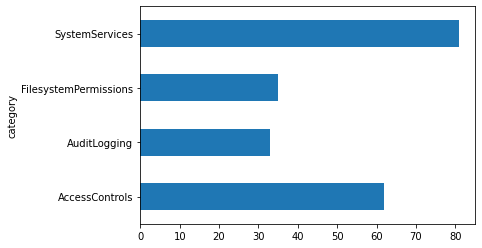

In [0]:
df.groupby('category').full_description.count().plot(kind='barh')

In [0]:
labels = list(df.category)
text = list(df.full_description)

print(len(labels), 'labels')
print(len(text), 'text')

211 labels
211 text


In [0]:
cleaned_text = []

# Remove STOPWORDS from the text
for row in text:
  for word in STOPWORDS:
    token = ' ' + word + ' '
    cleaned_string = row.replace(token, ' ')

# Define training and NLTK parameters in one place

In [0]:
training_portion = 0.8

# Set max length for the vector to be the longest string
max_length = df.full_description.str.len().max() 

vocab_size = 50000
embedding_dim = 64
trunc_type = 'post'
padding_type = 'post'

# Token to be used for words outside of the vocab
oov_tok = '<OOV>'
pad_tok = '<PAD>'

In [0]:
# Split train test
def split_train_test(X, y, split_size):
  """ Split the data (X) and labels (y) into train and test 
  based on split_size

  return: train_X, train_y, test_X, test_y
  """
  train_size = int(len(X) * split_size)
  train_X = X[0:train_size]
  train_y = y[0:train_size]

  test_X = X[train_size:]
  test_y = y[train_size:]

  return (train_X, train_y), (test_X, test_y)

(train_text, train_labels), (test_text, test_labels) = split_train_test(text, 
                                                  labels, 
                                                  split_size=training_portion)

In [0]:
print(len(train_text), 'train_text')
print(len(train_labels), 'train_labels')
print(len(test_text), 'test_text')
print(len(test_labels), 'test_labels')

168 train_text
168 train_labels
43 test_text
43 test_labels


# Check distribution of shuffled train and test data

The shuffle routine above should have randomly allocated the train and test data for each of the 4 categories.

Watch this carefully to ensure that no single category is under-represented.

In a future release, we will split the train and test by each category if the accuracy is not ideal

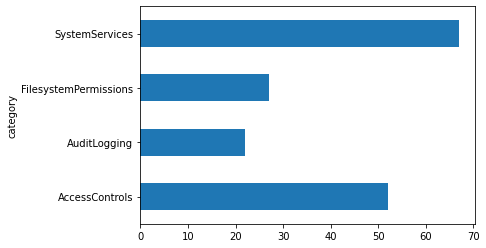

In [0]:
train_df = pd.DataFrame(train_labels, columns=['category'])
train_df.groupby('category')['category'].count().plot(kind='barh')

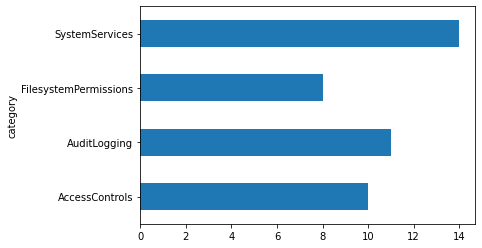

In [0]:
test_df = pd.DataFrame(test_labels, columns=['category'])
test_df.groupby('category')['category'].count().plot(kind='barh')

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      oov_token=oov_tok,
                      filters=',.\t\n')
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [0]:
# Remove stopwords to improve the accuracy
for key in STOPWORDS:
  word_index.pop(key, None)

In [0]:
word_index_reverse = {v:k for k,v in word_index.items()}
word_index_reverse[0] = pad_tok

In [0]:
dict(list(word_index.items())[:20])

{'#': 16,
 '-': 38,
 '-f': 34,
 '-s': 30,
 '<OOV>': 1,
 'access': 35,
 'command': 39,
 'could': 44,
 'ensure': 11,
 'file': 15,
 'files': 27,
 'following': 19,
 'password': 45,
 'permissions': 43,
 'run': 24,
 'set': 23,
 'system': 9,
 'systems': 46,
 'user': 26,
 'users': 22}

# Convert the training text to sequences

In [0]:
train_sequences = tokenizer.texts_to_sequences(train_text)

In [0]:
print(train_sequences[0])

[11, 43, 1, 331, 219, 1, 57, 1, 178, 276, 15, 160, 105, 50, 1, 1, 48, 1, 233, 9, 362, 1, 251, 166, 1, 363, 1, 1, 362, 1, 838, 1, 1, 252, 1, 11, 1, 1, 178, 276, 15, 1, 179, 1, 83, 147, 35, 307, 1, 1, 179, 1, 51, 1, 15, 43, 44, 1, 364, 365, 366, 1, 1, 277, 253, 24, 1, 19, 47, 1, 23, 43, 1, 178, 276, 53, 16, 116, 144, 331, 219, 16, 112, 473, 331, 219]


In [0]:
len(word_index)

2444

###Before padding
We see that the sequences are all currently in different lengths.  We need to pad them so that the neural network receives a fixed-length vector

In [0]:
for i in range(10):
  print(len(train_sequences[i]))

86
128
66
173
62
128
87
143
62
73


### After padding
The vectors are now padded to the max_length which was computed above based on the longest description field

In [0]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
for i in range(10):
  print(len(train_padded[i]))

2428
2428
2428
2428
2428
2428
2428
2428
2428
2428


# Convert test text to sequence
Repeat the same steps as above

In [0]:
test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
for i in range(10):
  print(len(test_padded[i]))

2428
2428
2428
2428
2428
2428
2428
2428
2428
2428


# Labels


In [0]:
print(set(labels))

{'FilesystemPermissions', 'AccessControls', 'SystemServices', 'AuditLogging'}


In [0]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

In [0]:
print(training_label_seq[0])
print(training_label_seq.shape)
print(test_label_seq[0])
print(test_label_seq.shape)

[1]
(168, 1)
[2]
(43, 1)


In [0]:
print(label_tokenizer.word_index)

{'systemservices': 1, 'accesscontrols': 2, 'filesystempermissions': 3, 'auditlogging': 4}


In [0]:
train_padded[0]
def decode_sequence(input_sequence):
  decoded_string = ''
  for i in range(len(input_sequence)):
    curr_word = word_index_reverse[input_sequence[i]]
    decoded_string = ' '.join([decoded_string, curr_word])
  return decoded_string

sequence = train_padded[0]
print(decode_sequence(sequence))

sequence = test_padded[0]
print(decode_sequence(sequence))

 ensure permissions <OOV> /etc/hosts deny <OOV> configured <OOV> '/etc/hosts deny' file contains network information <OOV> <OOV> used <OOV> many system applications <OOV> therefore must <OOV> readable <OOV> <OOV> applications <OOV> operate <OOV> <OOV> critical <OOV> ensure <OOV> <OOV> '/etc/hosts deny' file <OOV> protected <OOV> unauthorized write access although <OOV> <OOV> protected <OOV> default <OOV> file permissions could <OOV> changed either inadvertently <OOV> <OOV> malicious actions run <OOV> following commands <OOV> set permissions <OOV> '/etc/hosts deny' : # chown root:root /etc/hosts deny # chmod 644 /etc/hosts deny <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

# Model definition


In [0]:
# Training model hyperparameters
n_epochs = 10
#learning_rate = 0.0075
learning_rate = 0.008
batch_size = 32

In [0]:
model = tf.keras.Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
#model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(1024, 5, activation='relu'))
model.add(GlobalAveragePooling1D())
#model.add(Dense(64, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2428, 64)          3200000   
_________________________________________________________________
conv1d (Conv1D)              (None, 2424, 1024)        328704    
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 4,056,069
Trainable params: 4,056,069
Non-trainable params: 0
_________________________________________________________________


In [0]:
opt = Adam(lr=learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
history = model.fit(train_padded, training_label_seq, epochs=n_epochs, batch_size=batch_size, validation_data=(test_padded, test_label_seq), verbose=1)

Epoch 1/10
6/6 [==============================] - 1s 214ms/step - loss: 1.7144 - accuracy: 0.2679 - val_loss: 1.5090 - val_accuracy: 0.2326
Epoch 2/10
6/6 [==============================] - 1s 136ms/step - loss: 1.4167 - accuracy: 0.3095 - val_loss: 1.5452 - val_accuracy: 0.2326
Epoch 3/10
6/6 [==============================] - 1s 137ms/step - loss: 1.2741 - accuracy: 0.4524 - val_loss: 1.4044 - val_accuracy: 0.3953
Epoch 4/10
6/6 [==============================] - 1s 135ms/step - loss: 1.0901 - accuracy: 0.6012 - val_loss: 1.2881 - val_accuracy: 0.4419
Epoch 5/10
6/6 [==============================] - 1s 136ms/step - loss: 0.7721 - accuracy: 0.6845 - val_loss: 1.1167 - val_accuracy: 0.4884
Epoch 6/10
6/6 [==============================] - 1s 138ms/step - loss: 0.5697 - accuracy: 0.7381 - val_loss: 1.0965 - val_accuracy: 0.5814
Epoch 7/10
6/6 [==============================] - 1s 136ms/step - loss: 0.4453 - accuracy: 0.8274 - val_loss: 1.2559 - val_accuracy: 0.6279
Epoch 8/10
6/6 [====

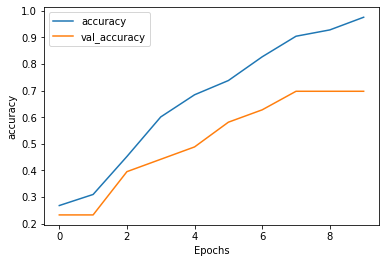

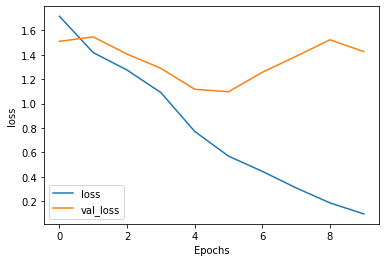

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
#text = ['Ensure that the password length of the configuration is more than 14 characters, and is not reused across systems']
text = ['If there are no operational requirements for the service, it should be disabled from the startup configuration']
#text = ['Ensure that world-writeable files are reviewed periodically']
#text = ["1.1.1.1 Ensure mounting of cramfs filesystems is disabled - lsmodThe 'cramfs' filesystem type is a compressed read-only Linux filesystem embedded in small footprint systems. A 'cramfs' image can be used without having to first decompress the image.Removing support for unneeded filesystem types reduces the local attack surface of the server. If this filesystem type is not needed, disable it."]
#text = ['4.1.1.1 Ensure audit log storage size is configured Configure the maximum size of the audit log file. Once the log reaches the maximum size, it will be rotated and a new log file will be started.It is important that an appropriate size is determined for log files so that they do not impact the system and audit data is not lost.']
seq = tokenizer.texts_to_sequences(text)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
label_lookup = ['systemservices', 'accesscontrols', 'filesystempermissions', 'auditlogging']

# Set numpy formatting
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(pred, label_lookup[np.argmax(pred)-1])

[[0.00 0.95 0.00 0.00 0.05]] systemservices


In [0]:
model.save_weights('./checkpoint_acc_8140')